<div class='alert alert-info' style='text-align:center'><h1>Smart cropping with YOLOV5</h1>
- yet another chest x-ray processing notebook -</div>

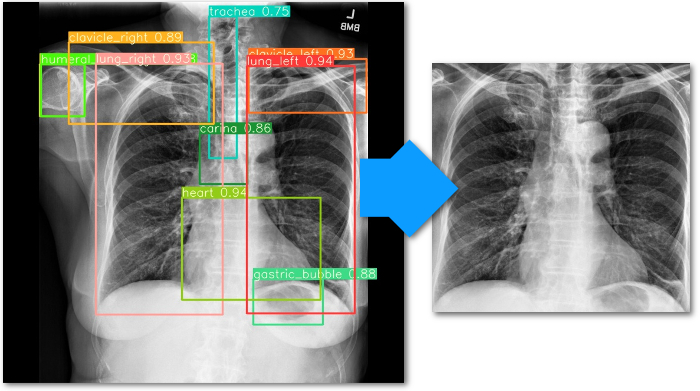

#### **- Use a custom Torch/YOLOv5 anatomy detection model to detect specific anatomy on a CXR.**
#### **- Crop the image to the bounds of the detected anatomy.**
#### **- Scale the original annotated bounding boxes to fit the cropped image.**

- I trained the **cxr-anatomy-detection** model on a small set of chest x-rays from the train set.
- Train notebook -> https://www.kaggle.com/davidbroberts/chest-anatomy-detection-train
- Train dataset -> https://www.kaggle.com/davidbroberts/chest-anatomy-yolov5-train-set
- Anatomy detection inference notebook -> https://www.kaggle.com/davidbroberts/cxr-anatomy-detection-with-yolov5
- Model dataset -> https://www.kaggle.com/davidbroberts/cxr-anatomy-detection
- It can detect Lungs, Heart, Clavicles, Shoulders, Carina, Trachea and Gastric Bubble .. pretty accurately, but the carina is hard to find sometimes!
- The model prediction exports bounding box data for each section of anatomy.
- In this notebook, I'll use the lung fields to crop the image, and then scale the original bounding boxes.

The class predictions and their BBs are stored in the text file **/kaggle/working/runs/detect/exp/labels/test.txt** and can be filtered as needed. The classes are:
- 0 = Left Lung
- 1 = Right Lung
- 2 = Left Clavicle
- 3 = Right Clavicle
- 4 = Left Humeral Head
- 5 = Right Humeral Head
- 6 = Heart
- 7 = Gastric Bubble
- 8 = Carina
- 9 = Trachea

### - Load stuff and install YOLOV5

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
import json
import torch
from skimage import exposure
import math
from shutil import copyfile
from IPython.display import Image, clear_output

In [ ]:
# D/L and install YOLOv5
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -qr requirements.txt
%cd ../
clear_output()
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

In [ ]:
# Copy the requirements file over so we don't have to change directory later. Is there an argument for this?
copyfile('yolov5/requirements.txt', '/kaggle/working/requirements.txt');

In [ ]:
# Load the image dataframe so we can get BB coords
base_path = "/kaggle/input/siim-covid19-detection/"
images_df = pd.read_csv(os.path.join(base_path,"train_image_level.csv"))

### - Define some functions

In [ ]:
# Load a DICOM file
def load_file(filename):
    img = pydicom.dcmread(filename)
    pixels = img.pixel_array
    max_pixel = np.max(pixels)

    if img.PhotometricInterpretation == "MONOCHROME1":
        pixels = max_pixel - pixels
        
    pixels = exposure.equalize_adapthist(pixels)
    pixels = (pixels * 255).astype(np.uint8)
    return pixels

In [ ]:
# Convert YOLO coords to pixel coords
def box2coords(x,y,w,h,image_w, image_h):
    x1, y1 = round((x-w/2) * image_w), round((y-h/2) * image_h)
    x2, y2 = round((x+w/2) * image_w), round((y+h/2) * image_h)
    return x1, y1, x2, y2

In [ ]:
# Function to get the BB data from the images DF
def get_boxes(image_id):
    
    image = image_id.replace('.dcm','_image')
    ti = images_df[images_df['id'] == image]
    bx = [[],[]]
    bx[0] = [0,0,0,0,""]
    bx[1] = [0,0,0,0,""]
    
    if str(ti['boxes'].values[0]) != "nan":
        box = str(ti['boxes'].values[0]).replace("'","\"")
        boxes = json.loads(box)
        lab = ti['label'].values[0].split(" ")
        i = 0
        for b in boxes:
            bx[i] = [int(b['x']), int(b['y']), int(b['width']),int(b['height']),lab[0]]
            i = i+1
    return bx

In [ ]:
# This function draws boxes on images, one line at a time
def draw_boxes(boxes, z):

    for i in boxes:     
        # Top
        x = [i[0] - z[0], i[0] + i[2] - z[0]]        # [ x1 , x2 ]
        y = [i[1] - z[1], i[1] - z[1]]               # [ y1 , y2 ]
        plt.plot(x,y, color='#ff8838', linewidth=2)
        
        # Bottom
        y = [i[1] + i[3] - z[1], i[1] + i[3] - z[1]]
        plt.plot(x,y, color='#ff8838', linewidth=2)
        
        # Left
        x = [i[0] - z[0], i[0] - z[0]]
        y = [i[1] - z[1], i[1] + i[3] - z[1]]
        plt.plot(x,y, color='#ff8838', linewidth=2)

        # Right         
        x = [i[0] + i[2] - z[0], i[0] + i[2] - z[0]]
        plt.plot(x,y, color='#ff8838', linewidth=2)

In [ ]:
# Call YOLO detect.py with the image we exported
def detect():
    # Clean up results from the last run
    if os.path.exists('/kaggle/working/runs/detect/exp/labels/test.txt'):
        os.remove('/kaggle/working/runs/detect/exp/labels/test.txt')

    # Call yolo detect
    !python yolov5/detect.py --source test.jpg --weights ../input/cxr-anatomy-detection/anatomy_detection.pt --img 640 --exist-ok --line-thickness 10 --save-txt

### - Load and Predict

#### *Then crop the image to the anatomy*

In [ ]:
# Load one of these DICOM files

#filename = '../input/siim-covid19-detection/train/00fceac64e6a/38de9f0745e7/b98508598396.dcm'
#filename = '../input/siim-covid19-detection/train/01206a422293/875992cad804/f8ded2e15154.dcm'
#filename = '../input/siim-covid19-detection/train/0142feaef82f/8f0c767d4e3f/55e22c0c5de0.dcm'
#filename = '../input/siim-covid19-detection/train/0147e3c530f2/fbfa6b7a400e/6b730a1a4271.dcm'
filename = '../input/siim-covid19-detection/train/01494b9b4423/fb5ef1804d54/336db847af0e.dcm'
    
pixels = load_file(filename)

# Export a JPG for YOLO
cv2.imwrite('test.jpg',pixels);

# Run detect
detect()

# Get the predicted boxes into a dataframe
boxes = pd.read_csv("/kaggle/working/runs/detect/exp/labels/test.txt", delim_whitespace=True, header=None, index_col=False)

# Convert the normalized YOLO BB data of the predicted anatomy to pixel coords and add them to the dataframe
for index, row in boxes.iterrows():
    
    x, y, xx, yy = box2coords(row[1], row[2], row[3], row[4], pixels.shape[1], pixels.shape[0])
    boxes.at[index,'x'] = x
    boxes.at[index,'y'] = y
    boxes.at[index,'xx'] = xx
    boxes.at[index,'yy'] = yy
    
# Get only the lung coords .. class 0 and 1 .. you could choose shoulders or clavicles instead .. or all of them
lungs = boxes[(boxes[0] == 0) | (boxes[0] == 1)]
lungs.head()

# Figure out the max dimensions of the predicted anatomy, and crop the image to those coords
x1 = int(lungs['x'].min())
x2 = int(lungs['xx'].max())
y1 = int(lungs['y'].min())
y2 = int(lungs['yy'].max())

cropped = pixels[y1:y2, x1:x2]

# Get the annotated BB coordinates
bb = get_boxes(str(os.path.basename(filename)))

plt.figure(figsize=(16,16)) 

# Plot the original image with BBs
plt.subplot(2, 2, 1)
draw_boxes(bb, [0,0,0,0])
plt.imshow(pixels, cmap='gray')  

# Plot the predicted anatomy
plt.subplot(2, 2, 2)
img = cv2.imread('/kaggle/working/runs/detect/exp/test.jpg')
plt.imshow(img, cmap='gray')

# Plot the original image with no crop
plt.subplot(2, 2, 3)
draw_boxes(bb,[0,0,0,0])
plt.imshow(pixels,cmap='gray'); 

# Plot cropped image with scaled BBs
plt.subplot(2, 2, 4)
draw_boxes(bb,[x1,y1,x2,y2])
plt.imshow(cropped,cmap='gray');  

#### - Notice the image on the  bottom right is cropped, yet the original BB is still in the correct place.

### - Conclusion

- We can significantly reduce the noise in images by cropping out unnecessary parts of the image.
- Original bounding boxes can be scaled to match the cropped image.
- The cropped coords will need to be normalized back to YOLO format (Pascal VOC) and updated in the images DF.
- The image could/should be re-equalized based on the cropped coordinates. This eliminates unnecessary pixels in the histogram calculations and should result in a better distribution of pixels.